In [1]:
import pysal as ps
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from math import ceil

from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(0,1))
pts = PowerTransformer()
scaler = StandardScaler()

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN
from sklearn.decomposition import PCA

In [2]:
gdf = pd.read_csv('census_block_loc.csv',
                 encoding= 'utf-8', na_values=[':'], low_memory=False)

In [3]:
gdf = gpd.GeoDataFrame(
    gdf, geometry=gpd.points_from_xy(gdf.Latitude, gdf.Longitude))
gdf.head()

Latitude  Longitude        BlockCode     County State  \
0     40.48 -74.280000  340230076002012  Middlesex    NJ   
1     40.48 -74.276834  340230076005000  Middlesex    NJ   
2     40.48 -74.273668  340230076003018  Middlesex    NJ   
3     40.48 -74.270503  340230076003004  Middlesex    NJ   
4     40.48 -74.267337  340230074021000  Middlesex    NJ   

                     geometry  
0  POINT (40.48000 -74.28000)  
1  POINT (40.48000 -74.27683)  
2  POINT (40.48000 -74.27367)  
3  POINT (40.48000 -74.27050)  
4  POINT (40.48000 -74.26734)

In [21]:
df = pd.read_csv('nyc_census_tracts.csv',
                 encoding= 'utf-8', na_values=[':'], low_memory=False)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CensusTract      2167 non-null   int64  
 1   County           2167 non-null   object 
 2   Borough          2167 non-null   object 
 3   TotalPop         2167 non-null   int64  
 4   Men              2167 non-null   int64  
 5   Women            2167 non-null   int64  
 6   Hispanic         2128 non-null   float64
 7   White            2128 non-null   float64
 8   Black            2128 non-null   float64
 9   Native           2128 non-null   float64
 10  Asian            2128 non-null   float64
 11  Citizen          2167 non-null   int64  
 12  Income           2101 non-null   float64
 13  IncomeErr        2101 non-null   float64
 14  IncomePerCap     2121 non-null   float64
 15  IncomePerCapErr  2121 non-null   float64
 16  Poverty          2125 non-null   float64
 17  ChildPoverty  

In [22]:
df = df[['CensusTract','Hispanic','White','Black','Native','Asian']]
df.head()

CensusTract   Men  Women  Hispanic  White  Black  Native  Asian
0  36005000100  7133    570      29.9    6.1   60.9     0.2    1.6
1  36005000200  2659   2744      75.8    2.3   16.0     0.0    4.2
2  36005000400  2896   3019      62.7    3.6   30.7     0.0    0.3
3  36005001600  2558   3321      65.1    1.6   32.4     0.0    0.0
4  36005001900  1206   1385      55.4    9.0   29.0     0.0    2.1

In [8]:
pd.isnull(df).sum() > 0

CensusTract    False
Men            False
Women          False
Hispanic        True
White           True
Black           True
Native          True
Asian           True
dtype: bool

In [9]:
print(df[df['Hispanic'].isnull()])

      CensusTract  Men  Women  Hispanic  White  Black  Native  Asian
97    36005016300    0      0       NaN    NaN    NaN     NaN    NaN
103   36005017100    0      0       NaN    NaN    NaN     NaN    NaN
180   36005024900    0      0       NaN    NaN    NaN     NaN    NaN
402   36047008600    0      0       NaN    NaN    NaN     NaN    NaN
452   36047015400    0      0       NaN    NaN    NaN     NaN    NaN
470   36047017500    0      0       NaN    NaN    NaN     NaN    NaN
472   36047017700    0      0       NaN    NaN    NaN     NaN    NaN
684   36047040700    0      0       NaN    NaN    NaN     NaN    NaN
879   36047066600    0      0       NaN    NaN    NaN     NaN    NaN
897   36047070203    0      0       NaN    NaN    NaN     NaN    NaN
1011  36047096000    0      0       NaN    NaN    NaN     NaN    NaN
1079  36047118000    0      0       NaN    NaN    NaN     NaN    NaN
1099  36047990100    0      0       NaN    NaN    NaN     NaN    NaN
1100  36061000100    0      0     

In [23]:
print(df.shape)
df = df.dropna()
print(df.shape)

(2167, 8)
(2128, 8)


In [24]:
df['total']=df['Hispanic']+df['White']+df['Black']+df['Native']+df['Asian']
df['Hispanic'] = round(df['Hispanic']/df['total'],3)
df['White'] = round(df['White']/df['total'],3)
df['Black'] = round(df['Black']/df['total'],3)
df['Native'] = round(df['Native']/df['total'],3)
df['Asian'] = round(df['Asian']/df['total'],3)

In [25]:
df.sample()

CensusTract    Men  Women  Hispanic  White  Black  Native  Asian  total
1132  36061003200  0.471    1.0     0.059  0.776  0.037     0.0  0.128   98.9

In [26]:
gdf = gdf[gdf.County.isin(['Bronx','Kings','New York','Queens','Richmond'])]
gdf['Tract'] = gdf.BlockCode // 10000

ppd = pd.merge(gdf, df, left_on='Tract', right_on='CensusTract', how='inner').reset_index()
ppd.shape
ppd.sample(3)

index   Latitude  Longitude        BlockCode    County State  \
6722   6722  40.706131 -73.852613  360810641021007    Queens    NY   
3414   3414  40.617940 -74.093216  360850047001000  Richmond    NY   
2203   2203  40.624724 -74.178693  360850291021022  Richmond    NY   

                        geometry        Tract  CensusTract    Men  Women  \
6722  POINT (40.70613 -73.85261)  36081064102  36081064102  0.318  0.997   
3414  POINT (40.61794 -74.09322)  36085004700  36085004700  0.471  1.000   
2203  POINT (40.62472 -74.17869)  36085029102  36085029102  0.468  1.000   

      Hispanic  White  Black  Native  Asian  total  
6722     0.065  0.935  0.000   0.000  0.000  100.0  
3414     0.125  0.732  0.077   0.010  0.055   98.3  
2203     0.211  0.673  0.052   0.003  0.061   98.4

In [27]:
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

In [28]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

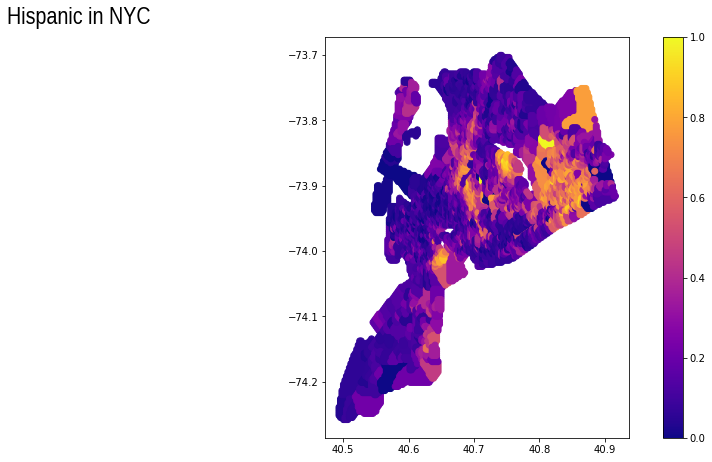

In [29]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
ppd.plot(column='Hispanic', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle(f"Hispanic in NYC", x=0.025, size=24, **tfont);
#plt.savefig('Cluster_IMD_Score_Raw.png', dpi=150)

In [30]:
ppd = ppd[['Tract','geometry','Hispanic','White','Black','Native','Asian']].copy()
ppd.head()

Tract                    geometry    Men  Women  Hispanic  White  \
0  36085024402  POINT (40.49357 -74.25151)  0.477    1.0     0.037  0.845   
1  36085024402  POINT (40.49357 -74.24834)  0.477    1.0     0.037  0.845   
2  36085024402  POINT (40.49357 -74.24518)  0.477    1.0     0.037  0.845   
3  36085024402  POINT (40.49357 -74.24201)  0.477    1.0     0.037  0.845   
4  36085024402  POINT (40.49357 -74.23884)  0.477    1.0     0.037  0.845   

   Black  Native  Asian  
0  0.006     0.0  0.112  
1  0.006     0.0  0.112  
2  0.006     0.0  0.112  
3  0.006     0.0  0.112  
4  0.006     0.0  0.112

In [31]:
to_cluster = ppd[['Tract','Hispanic','White','Black','Native','Asian']].set_index('Tract').copy()
to_cluster.head()

Men  Women  Hispanic  White  Black  Native  Asian
Tract                                                           
36085024402  0.477    1.0     0.037  0.845  0.006     0.0  0.112
36085024402  0.477    1.0     0.037  0.845  0.006     0.0  0.112
36085024402  0.477    1.0     0.037  0.845  0.006     0.0  0.112
36085024402  0.477    1.0     0.037  0.845  0.006     0.0  0.112
36085024402  0.477    1.0     0.037  0.845  0.006     0.0  0.112

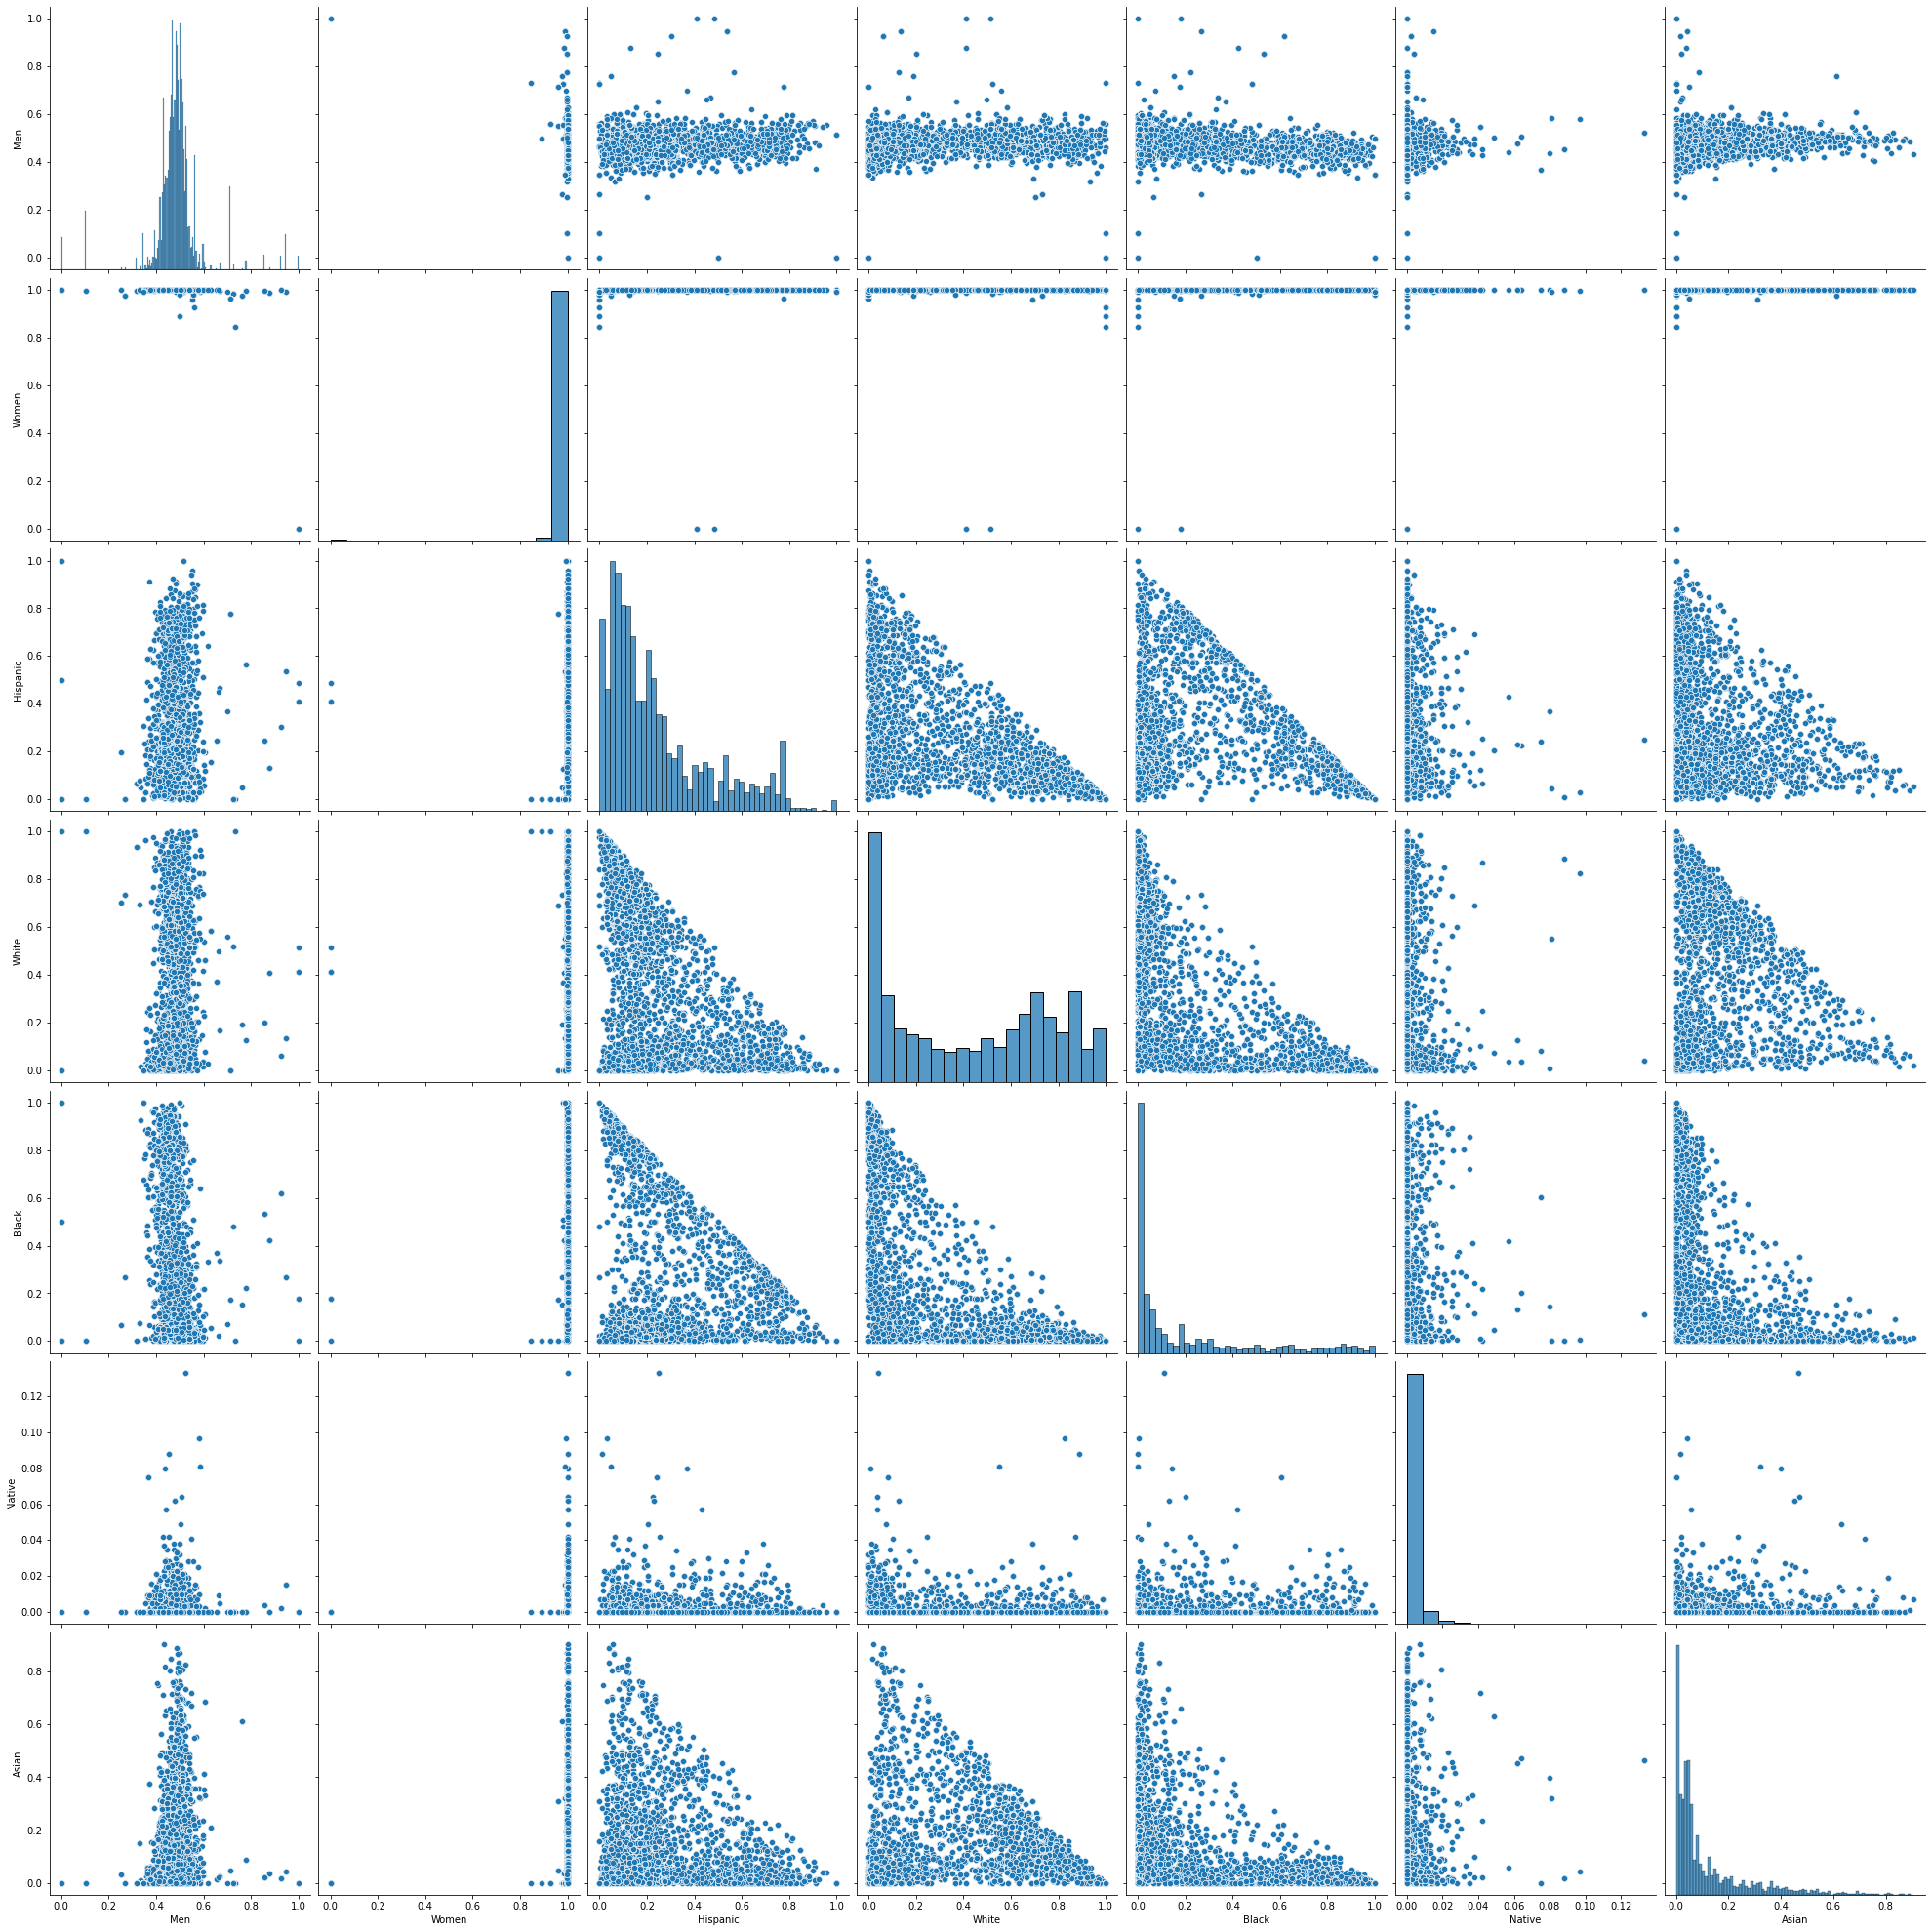

In [32]:
plot_norm = sns.pairplot(to_cluster,height = 4)

In [33]:
normed = to_cluster.copy()
for c in to_cluster.columns.values:
    normed[c] = pts.fit_transform(to_cluster[c].values.reshape(-1,1))
normed.sample(5)

Men     Women  Hispanic     White     Black    Native  \
Tract                                                                     
36005009300  0.764877  0.349759  1.714281 -1.323068  0.840865  0.469530   
36005050400  2.234790 -4.102600  1.776656 -1.367961  0.465978 -0.516707   
36081099100 -0.432442  0.349759 -0.298421  0.895012 -1.031347 -0.516707   
36047001800  4.513713 -2.681598  1.383315 -0.878503  0.876839  2.281990   
36047044900 -0.314598  0.349759  1.126445 -0.820095  1.182079 -0.516707   

                Asian  
Tract                  
36005009300 -1.288396  
36005050400 -0.339295  
36081099100  0.634971  
36047001800 -0.421894  
36047044900 -0.561100

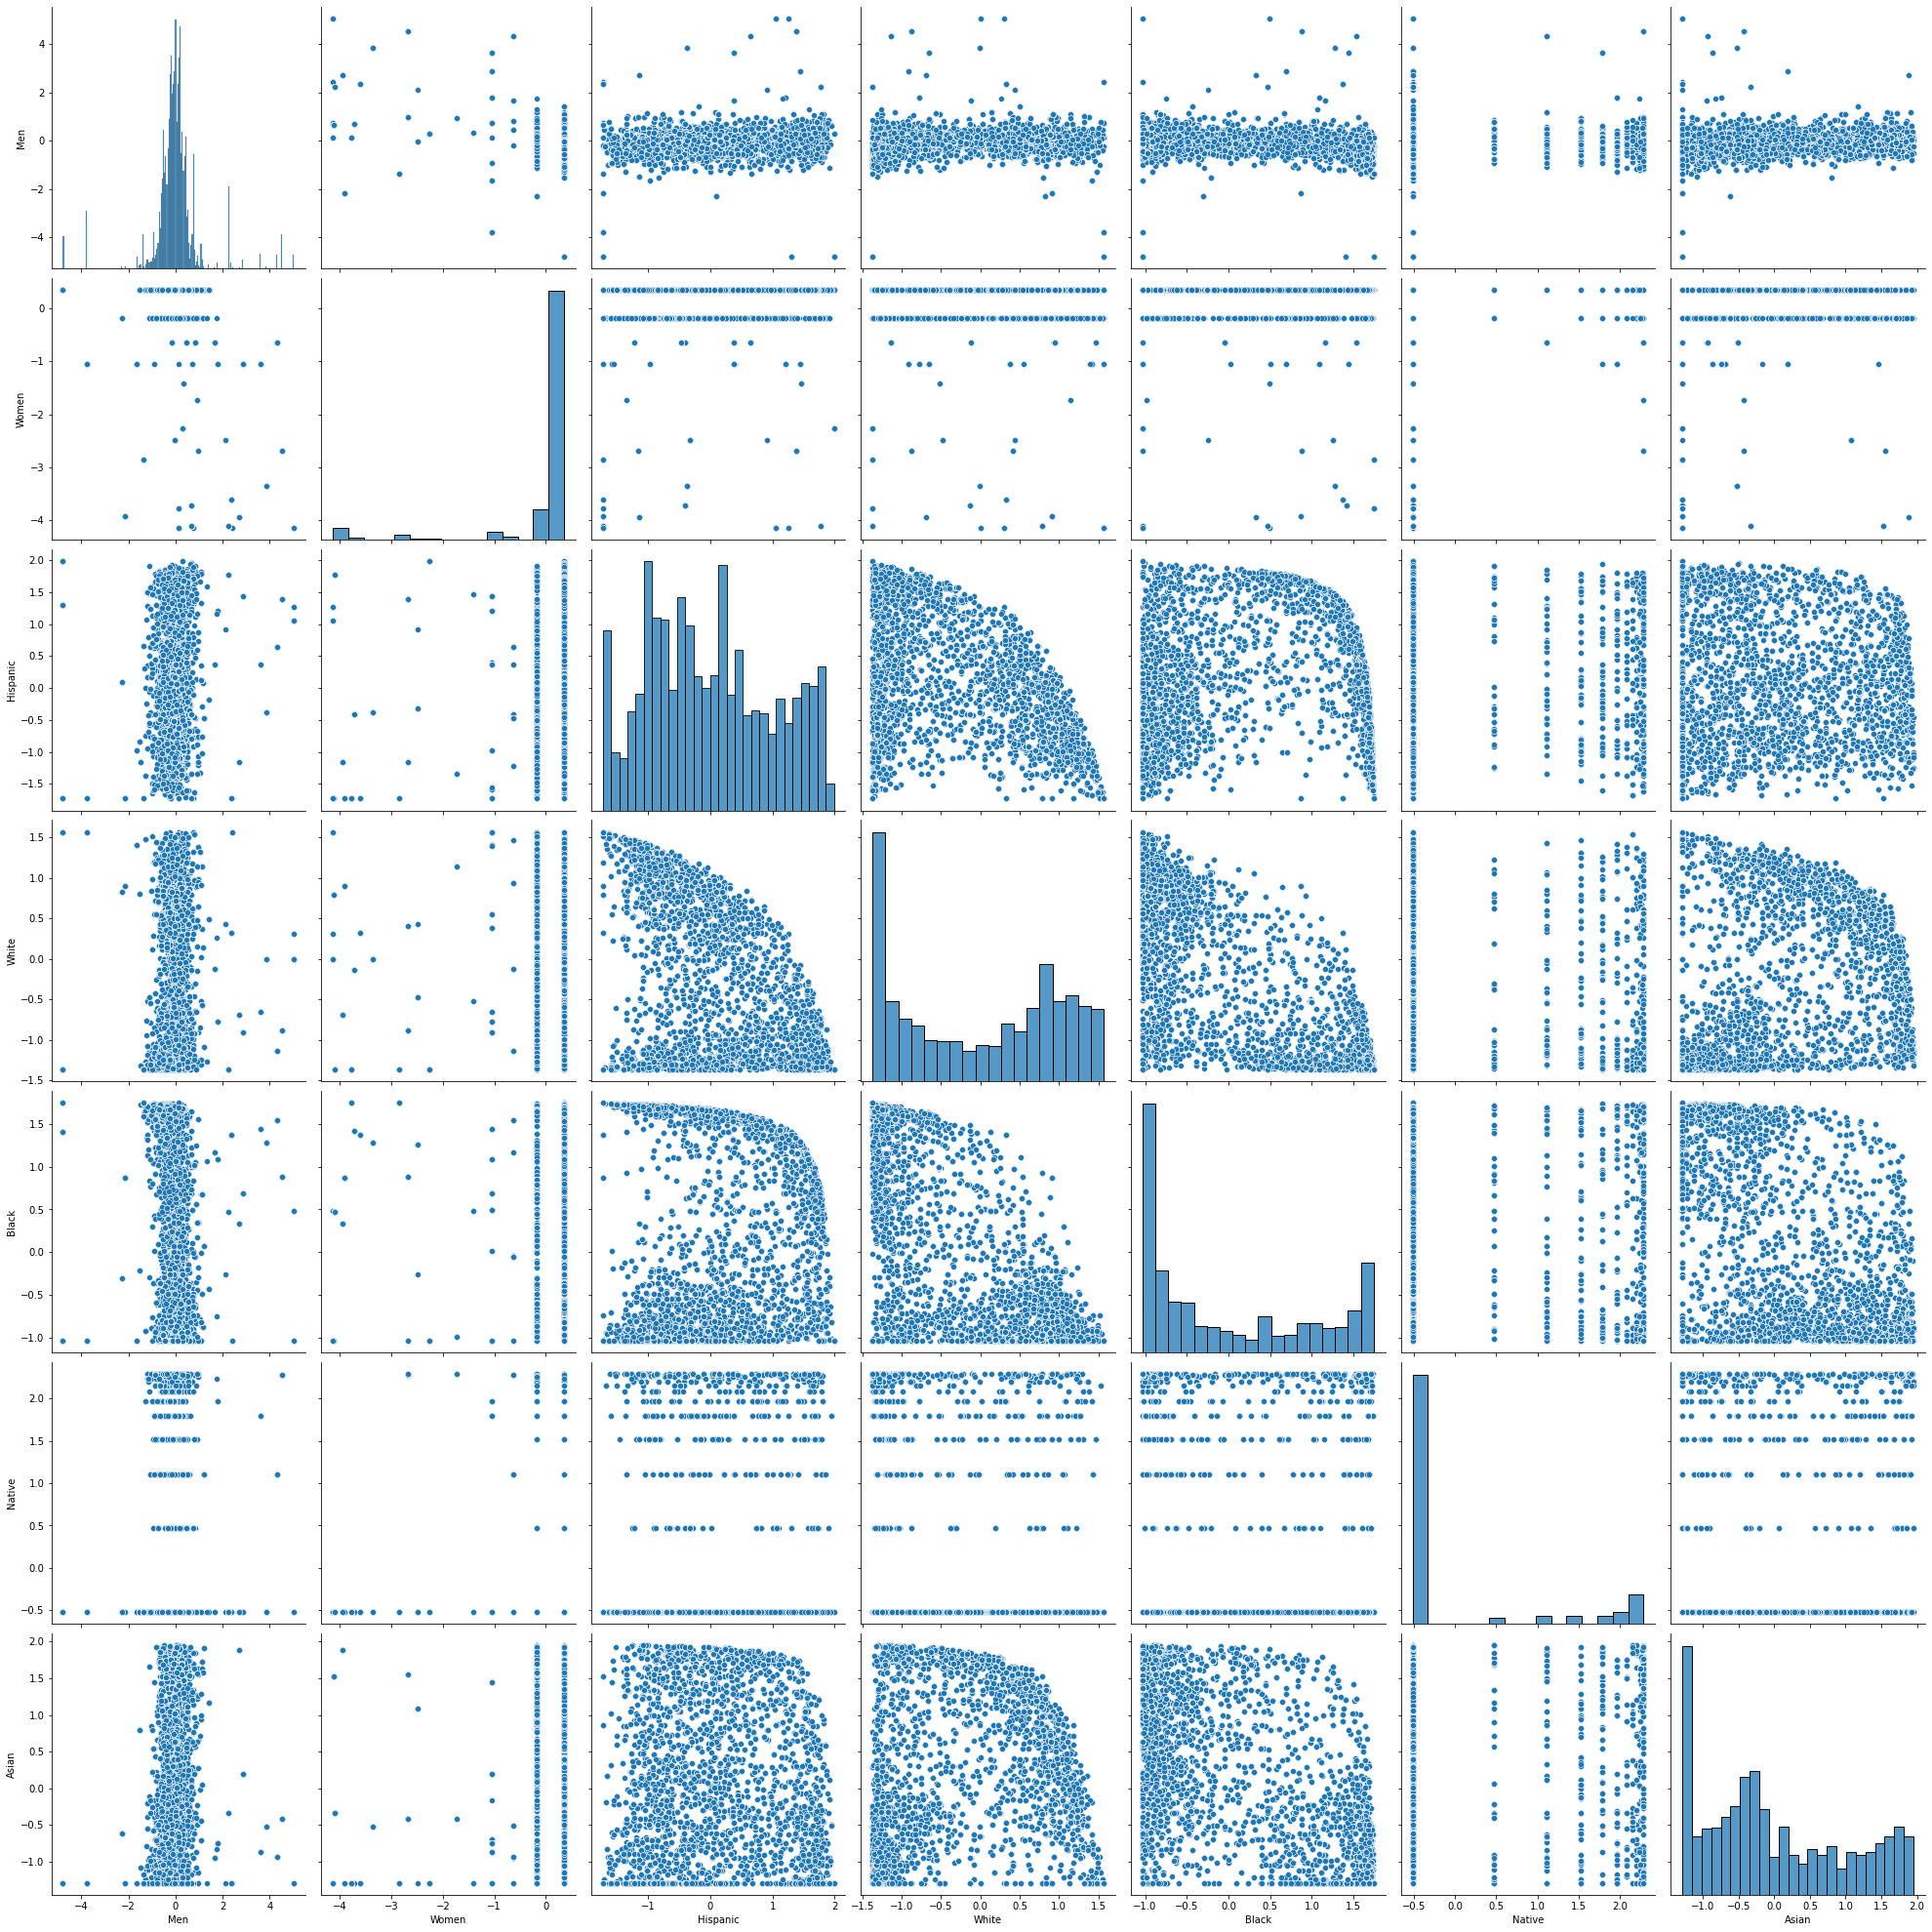

In [34]:
plot_norm = sns.pairplot(normed,height = 4)

In [35]:
rand_st_int = 10 
pca = PCA(random_state=rand_st_int)

normed_pca = pca.fit_transform(normed)
print('Explained variance ratio of each component:')
print(pca.explained_variance_ratio_)

Explained variance ratio of each component:
[0.31738307 0.19099735 0.18185361 0.13878658 0.09078429 0.06762258
 0.01257252]


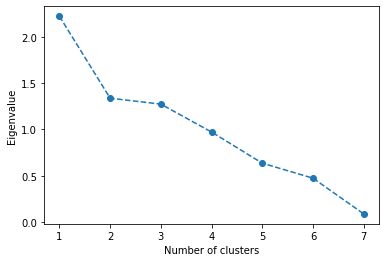

In [36]:
dfpc = pd.DataFrame({'eigenvalue':pca.explained_variance_,
             'PC':list(range(1, pca.n_components_ + 1))})

plt.plot(dfpc['PC'], dfpc['eigenvalue'], marker='o', linestyle = '--')
plt.xlabel('Number of clusters')
plt.ylabel('Eigenvalue')
plt.show()

In [37]:
pca = PCA(n_components = 2)

normed_pca = pca.fit_transform(normed)
print('Explained variance ratio of each component:')
print(pca.explained_variance_ratio_)

Explained variance ratio of each component:
[0.31738307 0.19099735]


In [38]:
list_var = normed.columns.tolist()
print(list_var)

['Men', 'Women', 'Hispanic', 'White', 'Black', 'Native', 'Asian']


In [39]:
df_PrincipleComp = pd.DataFrame(pca.components_, columns = list_var)
df_PrincipleComp

Men     Women  Hispanic     White     Black    Native     Asian
0  0.195053 -0.168201  0.449167 -0.605718  0.563609  0.068130 -0.206690
1  0.729781 -0.521632  0.119657  0.138626 -0.289017  0.157902  0.230913

In [40]:
score_pca = pca.transform(normed)
score_pca

array([[-2.04071417,  0.06950161],
       [-2.04071417,  0.06950161],
       [-2.04071417,  0.06950161],
       ...,
       [-0.95506631, -1.58892727],
       [-0.95506631, -1.58892727],
       [-0.95506631, -1.58892727]])

In [41]:
print('Eigenvalues of each component:')
print(pca.explained_variance_)

Eigenvalues of each component:
[2.22185243 1.33708428]


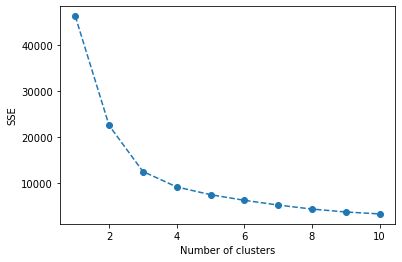

In [42]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='k-means++', random_state=0)
    km.fit(score_pca)
    # inertia is a concept in physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o', linestyle = '--')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [43]:
k_cluster = 3
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(score_pca)

KMeans(n_clusters=3, random_state=1)

In [44]:
ppd['Kmeans_Cluster'] = kmeans_method.labels_

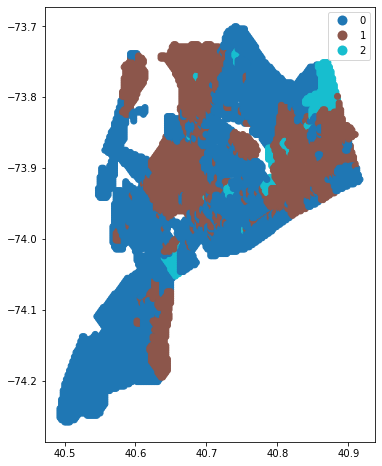

In [45]:
ppd.plot(column='Kmeans_Cluster', categorical=True, legend=True, figsize=(12,8));

In [46]:
ppd_kpca = pd.concat([ppd.reset_index(drop = True), pd.DataFrame(score_pca)],axis = 1)
ppd_kpca.columns.values[-2: ] = ['Component1','Component2']

In [47]:
ppd_kpca['Segement'] = ppd_kpca['Kmeans_Cluster'].map({0:'First',1:'Second',2:'Third',3:'Forth'})

In [34]:
ppd_kpca.head()

Tract                    geometry   Men  Women  Hispanic  White  \
0  36085024402  POINT (40.49357 -74.25151)  2023   2218       3.7   84.5   
1  36085024402  POINT (40.49357 -74.24834)  2023   2218       3.7   84.5   
2  36085024402  POINT (40.49357 -74.24518)  2023   2218       3.7   84.5   
3  36085024402  POINT (40.49357 -74.24201)  2023   2218       3.7   84.5   
4  36085024402  POINT (40.49357 -74.23884)  2023   2218       3.7   84.5   

   Black  Native  Asian  Kmeans_Cluster  Component1  Component2  Component3  \
0    0.6     0.0   11.2               0   -1.891278   -0.708992   -0.344715   
1    0.6     0.0   11.2               0   -1.891278   -0.708992   -0.344715   
2    0.6     0.0   11.2               0   -1.891278   -0.708992   -0.344715   
3    0.6     0.0   11.2               0   -1.891278   -0.708992   -0.344715   
4    0.6     0.0   11.2               0   -1.891278   -0.708992   -0.344715   

  Segement  
0    First  
1    First  
2    First  
3    First  
4    First

/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


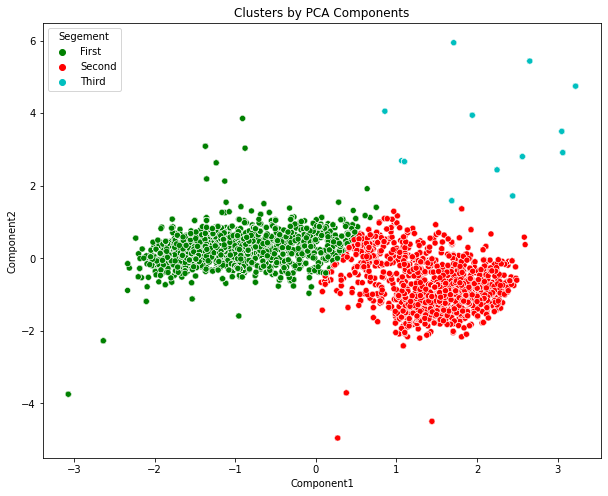

In [48]:
x_axis = ppd_kpca['Component1']
y_axis = ppd_kpca['Component2']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis,y_axis,hue = ppd_kpca['Segement'], palette = ['g','r','c'])
plt.title('Clusters by PCA Components')
plt.show()

KeyError: 'Component3'

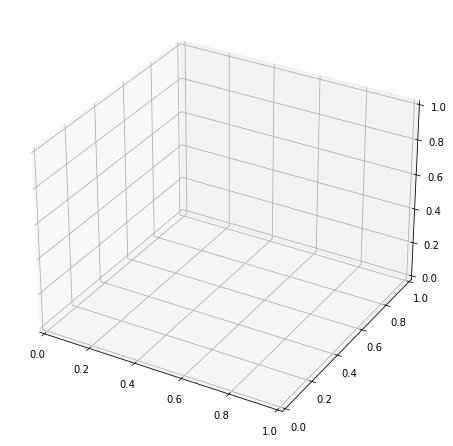

In [49]:
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("RdYlBu_r", 256).as_hex())

x = ppd_kpca['Component1']
y = ppd_kpca['Component2']
z = ppd_kpca['Component3']

# plot
sc = ax.scatter(x, y, z, s=40, c=ppd_kpca['Kmeans_Cluster'], marker='.', cmap=cmap, alpha=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

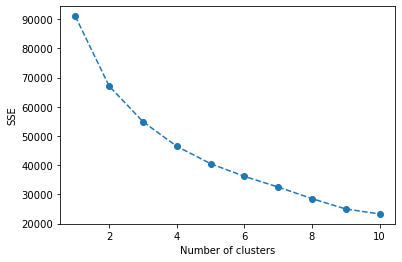

In [50]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='k-means++', random_state=0)
    km.fit(normed)
    # inertia is a concept in physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o', linestyle = '--')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [54]:
k_cluster = 2
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(normed)

KMeans(n_clusters=2, random_state=1)

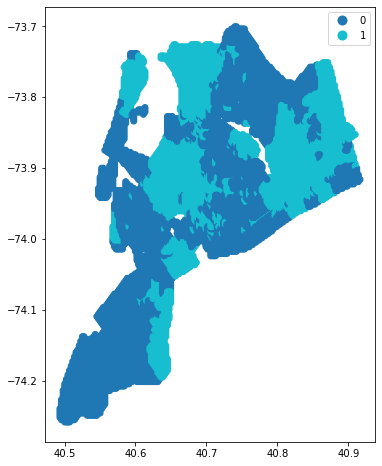

In [55]:
ppd['Kmeans_Cluster'] = kmeans_method.labels_
ppd.plot(column='Kmeans_Cluster', categorical=True, legend=True, figsize=(12,8));

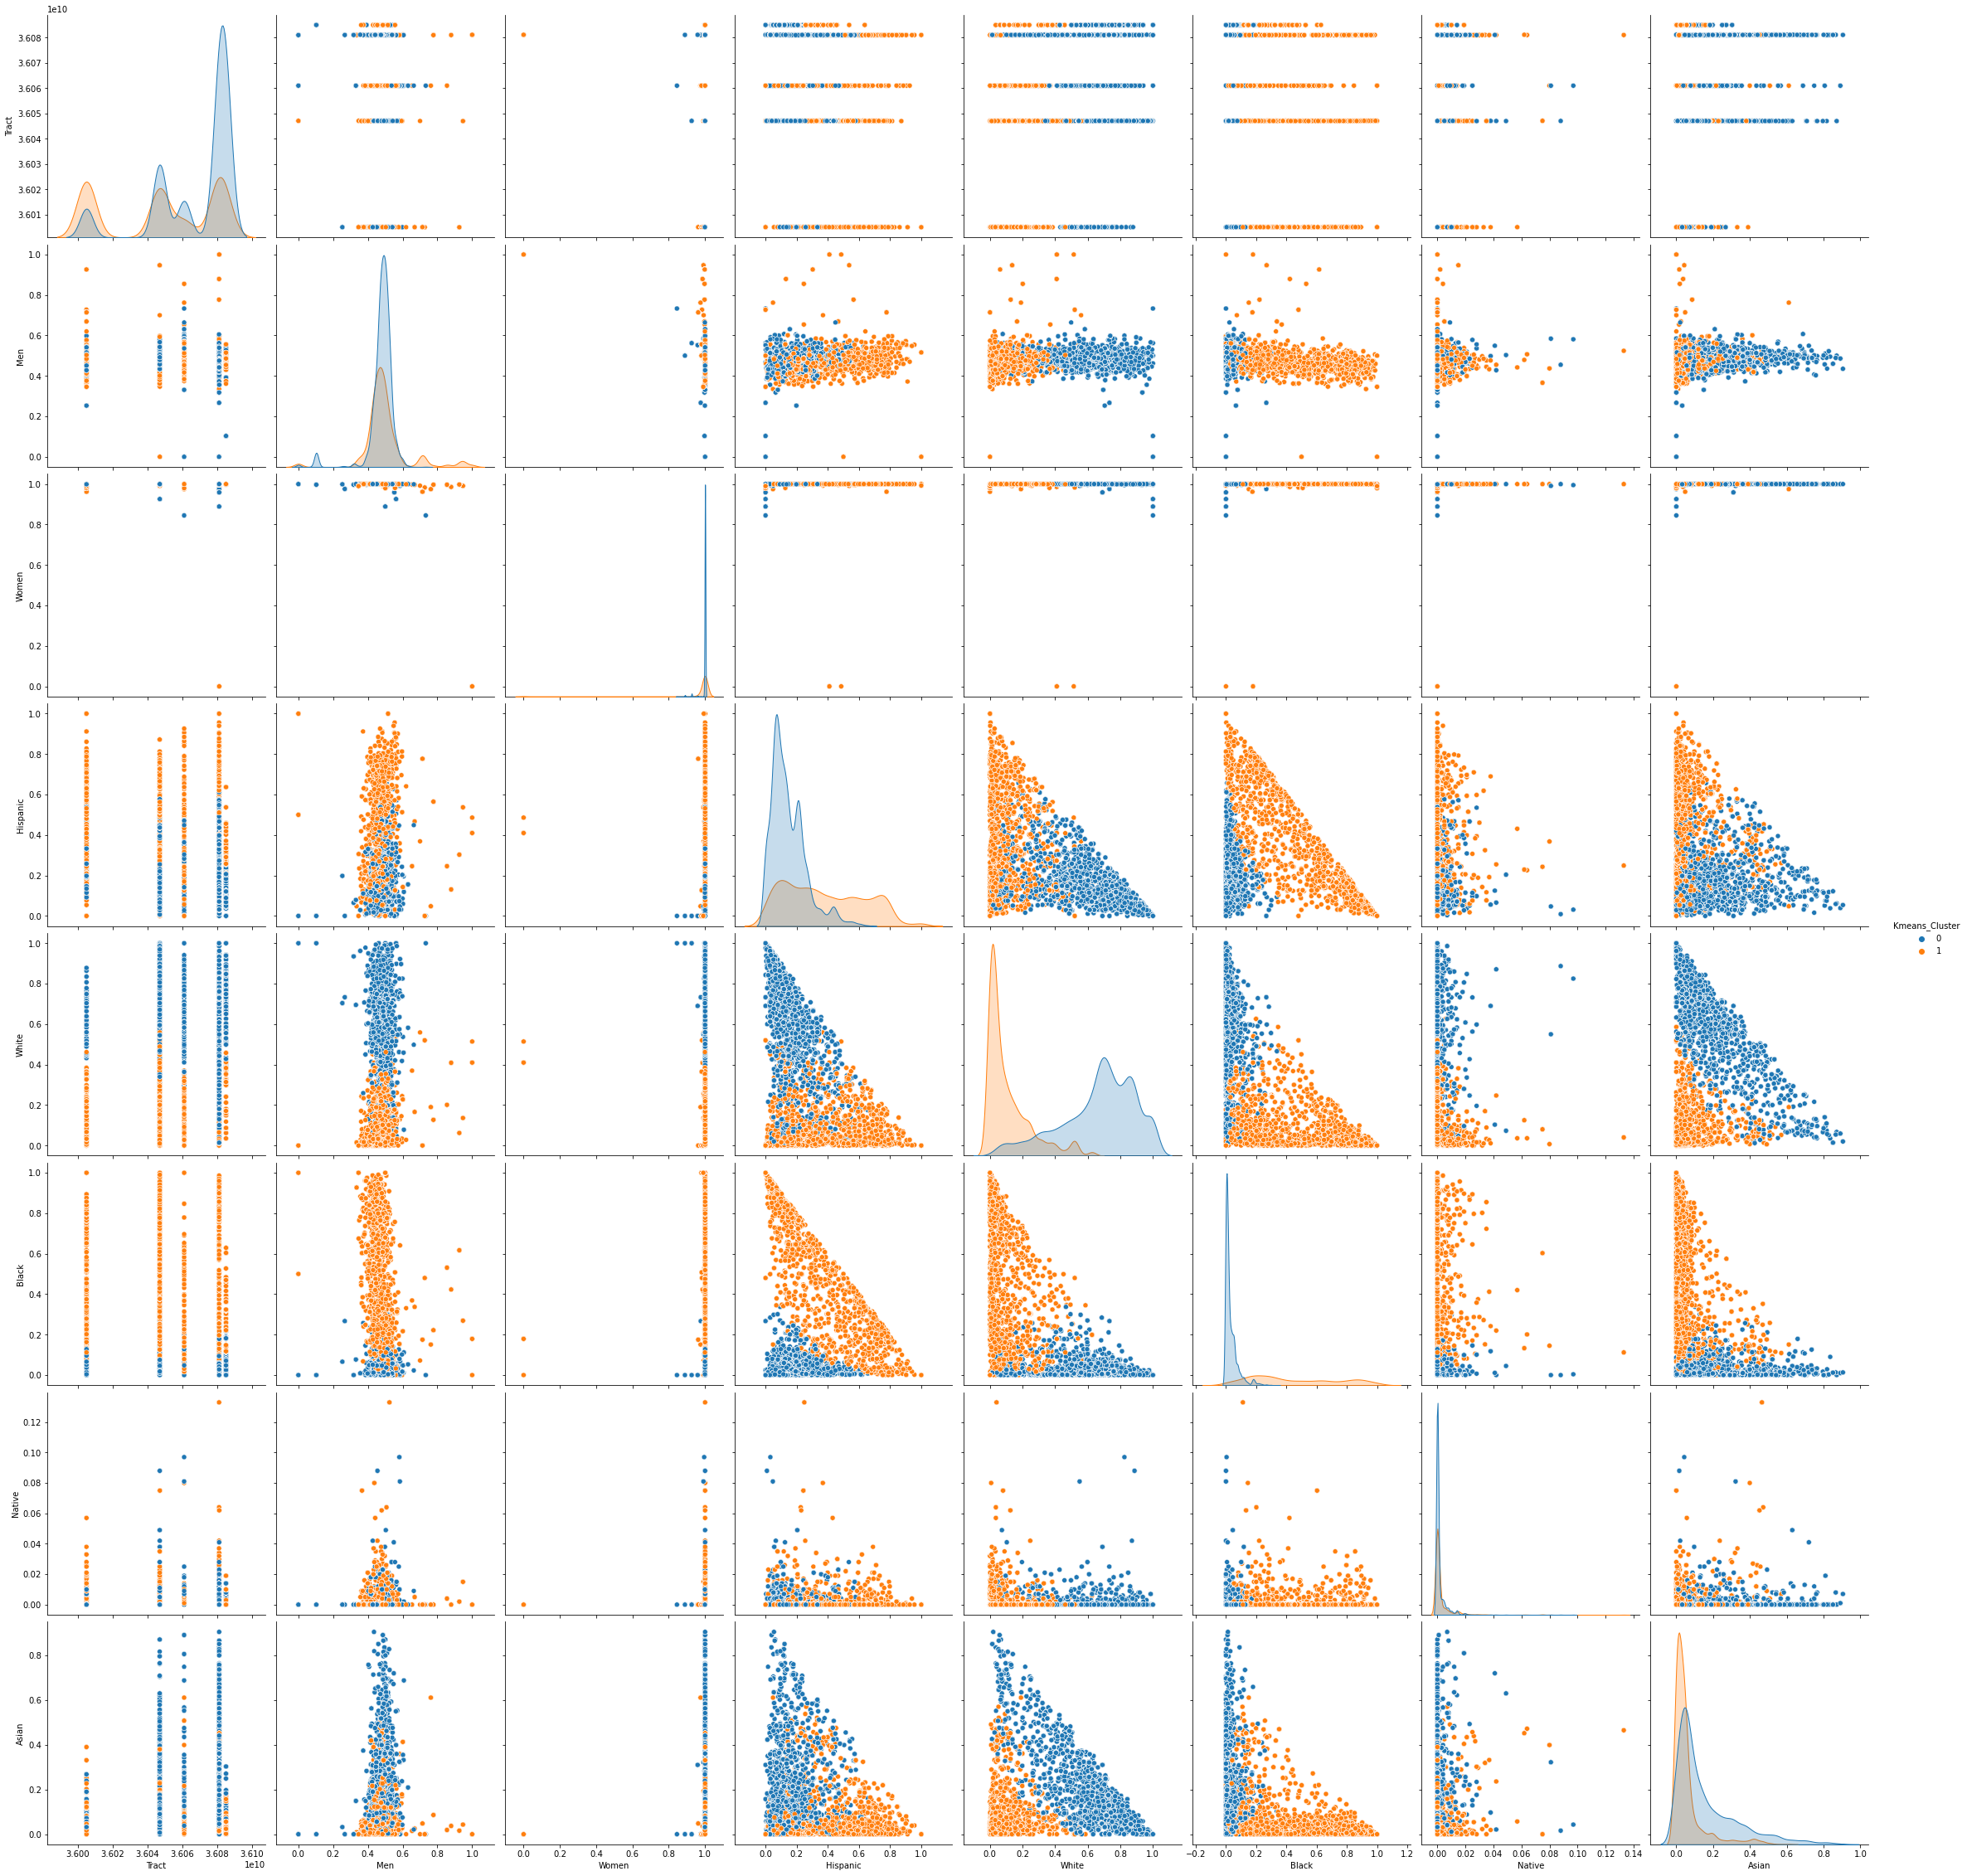

In [56]:
plot_norm = sns.pairplot(ppd,hue = 'Kmeans_Cluster',height = 4)